In [1]:
import pandas as pd
import os, sys
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import NnClass

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv(os.path.join('..', 'database', 'meta', 'mini_train_data.csv'))

In [3]:
# Extract labels and pixel values
labels = df['label'].values.astype(np.int64)
features = df.drop(columns=['label']).values.astype(np.float32)
features /= 255.0
# features = features.reshape(-1, 1, 313, 224)


labels = pd.get_dummies(labels, columns=['Label'], dtype=int).values   #onehot encoding
print("features shape:", features.shape)
print("labels shape:", labels.shape)

features shape: (653, 70113)
labels shape: (653, 10)


In [22]:
trset,vset=NnClass.tv_split(df,0.8,semilla=99)

trFeatures = trset.drop(columns=['label']).values.astype(np.float32)
trFeatures /= 255.0
trLabels=trset["label"].values.astype(np.int64)
trLabels = pd.get_dummies(trLabels, columns=['Label'], dtype=int).values   #onehot encoding

vFeatures = vset.drop(columns=['label']).values.astype(np.float32)
vFeatures /= 255.0
vLabels=vset["label"].values.astype(np.int64)
vLabels = pd.get_dummies(vLabels, columns=['Label'], dtype=int).values   #onehot encoding

fcnn=NnClass.Nn(trainX=trFeatures, trainY=trLabels,m=[500,100,50],seed=99)

Epoch 1/50 - Train Loss: 2.1743 - Val Loss: 2.3086
Epoch 11/50 - Train Loss: 2.1236 - Val Loss: 2.1352
Epoch 21/50 - Train Loss: 2.1232 - Val Loss: 2.1378
Epoch 31/50 - Train Loss: 2.1231 - Val Loss: 2.1395
Epoch 41/50 - Train Loss: 2.1231 - Val Loss: 2.1385


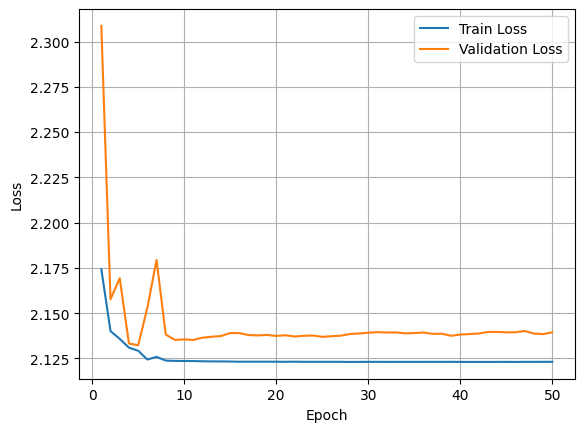

In [24]:
fcnn.trainUltimate(
          epochs=50, 
          lr=0.01, 
          batch_size=20, 
          optimizer='adam', 
          l2_lambda=0.0, 
          valX=vFeatures, 
          valy=vLabels, 
          early_stopping=True, 
          patience=5, 
          eval_interval=10, 
          lr_schedule=None)